In [1]:
import pandas as pd
import numpy as np
import gc
import warnings
import matplotlib.pyplot as plt

%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
# Load Data ---------------------------------------------------------------
path = 'C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/input_data/'

aisles = pd.read_csv(path + 'aisles.csv')
departments = pd.read_csv(path + 'departments.csv')
orderp = pd.read_csv(path + 'order_products__prior.csv')
ordert = pd.read_csv(path + 'order_products__train.csv')
orders = pd.read_csv(path + 'orders.csv')
products = pd.read_csv(path + 'products.csv')

###### Joining to product aisle and department names

In [3]:
products = pd.merge(products, aisles, on='aisle_id')
products = pd.merge(products, departments, on='department_id')
products = products[['product_id', 'aisle_id', 'department_id']]
del aisles, departments

###### Adding user_ids to order_train

In [4]:
orders_users = orders[['order_id', 'user_id']]
orders_users = orders_users[orders_users['order_id'].isin(ordert.order_id.values)]
ordert = pd.merge(ordert, orders_users, on='order_id')
del orders_users

In [5]:
len(np.unique(ordert.user_id.values))

131209

###### Joining orders data with prior data

In [6]:
orders_products = pd.merge(orders, orderp, on='order_id')
orders_products = pd.merge(orders_products, products, on='product_id')

In [7]:
del orderp, products
gc.collect()

110

###### Product general features

for each product:
* total number of orders (prod_orders)
* sum of reorders (prod_reorders)
* number of unique users who buy it (prod_first_orders)
* number of unque users who buy it more than 1 time (prod_second_orders)
* product reorder probability = prod_second_orders / prod_first_orders
* prod_reorder_times = 1 + prod_reorders / prod_first_orders
* prod_reorder_ratio = prod_reorders / prod_orders
* prod_average_order_hour_of_day (from me)
* prod_average_order_dow (from me)
* prod_frequency = prod_orders / total number of orders (from me)
* prod_reorder_frequency = prod_reorders / sum of total reorders (from me)
* prod_most_frequent_reoder_day (from me)
* product second reorder probability (from me)
* product aisle market share = aisle_orders / total_orders (from me)
* product deparment market share = department orders / total orders (from me)


In [8]:
prd = pd.DataFrame()

In [9]:
prd['prod_orders'] = orders_products.groupby('product_id')['order_id'].size()
prd['prod_reorders'] = orders_products.groupby('product_id')['reordered'].sum()
prd['prod_first_orders'] = orders_products.groupby('product_id')['user_id'].nunique()

In [10]:
temp = pd.DataFrame(orders_products.groupby('product_id')['user_id'].value_counts())
temp.rename(columns={'user_id' : 'counts'}, inplace=True)
temp.reset_index(inplace=True)
temp = temp[temp['counts'] > 1]
prd['prod_second_orders'] = temp.groupby('product_id')['counts'].size()
del temp
gc.collect()

70

In [11]:
temp = pd.DataFrame(orders_products.groupby('product_id')['user_id'].value_counts())
temp.rename(columns={'user_id' : 'counts'}, inplace=True)
temp.reset_index(inplace=True)
temp = temp[temp['counts'] > 2]
prd['prod_third_orders'] = temp.groupby('product_id')['counts'].size()
del temp
gc.collect()

35

In [12]:
prd['prod_reorder_probability'] = prd.prod_second_orders / prd.prod_first_orders
prd['prod_reorder_times'] = 1 + prd.prod_reorders / prd.prod_first_orders
prd['prod_reorder_ratio'] = prd.prod_reorders / prd.prod_orders
prd['prod_second_reorder_probability'] = prd.prod_third_orders / prd.prod_second_orders

In [13]:
prd['prod_average_order_hour_of_day'] = orders_products.groupby('product_id')['order_hour_of_day'].mean()
prd['prod_average_order_dow'] = orders_products.groupby('product_id')['order_dow'].mean()
prd['prod_frequency'] = prd.prod_orders / len(np.unique(orders_products.order_id.values))
prd['prod_reorder_frequency'] = prd.prod_reorders / orders_products.reordered.sum()

In [14]:
temp = orders_products[orders_products['reordered'] != 0]
temp = pd.DataFrame(temp.groupby('product_id')['order_dow'].value_counts())
temp.rename(columns={'order_dow' : 'order_dow_counts'}, inplace=True)
temp.reset_index(inplace=True)
temp['max'] = temp.groupby(['product_id'])['order_dow_counts'].transform(max)
temp['dif'] = temp['max'] - temp['order_dow_counts']
temp = temp[temp['dif'] == 0]
temp = pd.DataFrame(temp.groupby('product_id')['order_dow'].min())
temp.rename(columns={'order_dow' : 'prod_most_frequent_reroder_order_dow'}, inplace=True)

prd = prd.join(temp)

del temp
gc.collect()

76

In [15]:
prd['aisle_id'] = orders_products.groupby('product_id')['aisle_id'].min().astype(int)
prd['department_id'] = orders_products.groupby('product_id')['department_id'].min().astype(int)

In [16]:
temp = pd.DataFrame()
temp['aisle_orders'] = orders_products.groupby('aisle_id', as_index=False)['order_id'].size()
temp['prod_aisle_market_share'] = temp.aisle_orders / len(np.unique(orders_products.order_id.values))
temp.reset_index(inplace = True)
temp_temp = pd.DataFrame(orders_products.groupby('product_id')['aisle_id'].min())
temp_temp.reset_index(inplace=True)
temp_temp = temp_temp.merge(temp, on='aisle_id')

prd['prod_aisle_market_share']  = temp_temp.groupby('product_id')['prod_aisle_market_share'].min()
prd['aisle_orders']  = temp_temp.groupby('product_id')['aisle_orders'].min()

del temp, temp_temp
gc.collect()

42

In [17]:
temp = pd.DataFrame()
temp['department_orders'] = orders_products.groupby('department_id', as_index=False)['order_id'].size()
temp['prod_department_market_share'] = temp.department_orders / len(np.unique(orders_products.order_id.values))
temp.reset_index(inplace = True)
temp_temp = pd.DataFrame(orders_products.groupby('product_id')['department_id'].min())
temp_temp.reset_index(inplace=True)
temp_temp = temp_temp.merge(temp, on='department_id')

prd['prod_department_market_share']  = temp_temp.groupby('product_id')['prod_department_market_share'].min()
prd['department_orders']  = temp_temp.groupby('product_id')['department_orders'].min()


del temp, temp_temp
gc.collect()

84

In [18]:
prd['prod_market_share_in_aisle'] = prd.prod_orders / prd.aisle_orders
prd['prod_market_share_in_department'] = prd.prod_orders / prd.department_orders

In [19]:
temp = pd.DataFrame(orders_products.groupby(['product_id', 'user_id'], as_index=False)['reordered'].sum())
temp = pd.DataFrame(temp.groupby(['product_id'], as_index=False)['reordered'].apply(list))
temp.columns = ['reordered']

std = []
for row in temp.iterrows():
    std.append((row[0], np.std(row[1][0])))
std = pd.DataFrame(std,columns=['product_id', 'prod_reorder_std'])
prd['prod_reorder_std'] = std.groupby('product_id')['prod_reorder_std'].min()

del temp, std
gc.collect()

21

74

In [22]:
prd['prod_period'] = orders_products.groupby('product_id')['days_since_prior_order'].sum()

In [23]:
prd.drop(['prod_reorders', 'prod_first_orders', 'prod_second_orders', 'aisle_orders', 'department_orders'], axis=1, inplace=True)

###### User general features

for each user:
* total number of orders (user_orders)
* sum of days_since_prior_order (user_period)
* mean of days_since_prior_order (user_mean_days_since_prior)
* total number of ordered products (user_total_products)
* user_reorder_ratio = sum(user_reordered_products) / (total number of products without first order)
* total number of ordered unique products (user_distinct_products)
* user max reorder rate (from me)
* user mean reorder rate (from me)
* user average reorder (from me)
* user average hour of order (from me)
* user average order dow (from me)


In [24]:
users = pd.DataFrame()

In [25]:
temp = orders[orders['eval_set'] == 'prior']
users['user_orders'] = temp.groupby('user_id')['order_number'].max()
users['user_period'] = temp.groupby('user_id')['days_since_prior_order'].sum()
users['user_mean_days_since_prior'] = temp.groupby('user_id')['days_since_prior_order'].mean()
del temp

In [26]:
temp = pd.DataFrame(orders_products.groupby(['user_id', 'order_id'])['reordered'].sum())
temp.reset_index(inplace=True)

In [27]:
temp_products = pd.DataFrame(orders_products.groupby('order_id')['product_id'].apply(list))
temp_products.reset_index(inplace=True)
temp_products.columns = ['order_id', 'products_list']
temp_products['order_size'] = temp_products['products_list'].str.len() # defining order size
temp_products.drop(['products_list'], axis=1, inplace=True)
temp = pd.merge(temp, temp_products, on = 'order_id') 
temp['reorder_ratio'] = temp.reordered / temp.order_size

In [28]:
users['user_max_reorder_rate'] = temp.groupby('user_id')['reorder_ratio'].max()
users['user_mean_reorder_rate'] = temp.groupby('user_id')['reorder_ratio'].mean()
users['user_average_reorder'] = temp.groupby('user_id')['reordered'].mean()
users['user_average_order_hour_of_day'] = orders_products.groupby('user_id')['order_hour_of_day'].mean()
users['user_average_order_dow'] = orders_products.groupby('user_id')['order_dow'].mean()

In [29]:
del temp, temp_products
gc.collect()

91

In [30]:
us = pd.DataFrame()

In [31]:
us['user_total_products'] = orders_products.groupby('user_id')['product_id'].size()
us['user_distinct_products'] = orders_products.groupby('user_id')['product_id'].nunique()

In [32]:
temp = orders_products[orders_products['order_number'] > 1]
us['user_reorder_ratio'] = (orders_products.groupby('user_id')['reordered'].sum()
                           / temp.groupby('user_id')['product_id'].size())

In [33]:
del temp
gc.collect()

35

In [34]:
users = users.join(us)
users['user_average_basket'] = users.user_total_products / users.user_orders

In [35]:
del us
gc.collect()

28

In [36]:
users['user_distinct_aisles'] = orders_products.groupby('user_id')['aisle_id'].nunique()
users['user_distinct_departments'] = orders_products.groupby('user_id')['department_id'].nunique()

In [37]:
# f1_score = pd.read_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/reordered_basket_size_prediction/f1_score.csv')

In [38]:
# users['user_mean_f1_score'] = f1_score.groupby('user_id')['average_f1_score'].mean()
# del f1_score
# gc.collect()

###### Joining test and train orders data

In [39]:
temp = orders[orders['eval_set'] != 'prior'][['user_id', 'order_id', 'eval_set', 'days_since_prior_order', 'order_dow', 'order_hour_of_day']]  
temp.rename(columns={'days_since_prior_order' : 'time_since_last_order'}, inplace=True)
temp.set_index('user_id', inplace=True)

In [40]:
users = users.join(temp)

In [41]:
del temp
gc.collect()

28

###### Database for training

for each user + product pair:
* total number of orders by user ordered the product (up_orders)
* first order number of the product for user (up_first_order)
* last order number of the product for user (up_last_order)
* mean add_to_cart_order of product for user (up_average_cart_position)
* up_order_rate = up_orders / user_orders
* up_orders_since_last_order = user_orders - up_last_order
* up_order_rate_since_first_order = up_orders/(user_orders - up_first_order + 1)
* up_sum_cart_position (from me)
* up_reoreder_frequency (from me)
* up_porduct_score (form me)

In [ ]:
data = pd.DataFrame()

In [ ]:
data['up_orders'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].size()
data['up_first_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].min()
data['up_last_order'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].max()
data['up_average_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].mean()

In [ ]:
data['up_sum_cart_position'] = orders_products.groupby(['user_id', 'product_id'])['add_to_cart_order'].sum()
data['up_product_period'] = orders_products.groupby(['user_id', 'product_id'])['days_since_prior_order'].sum()
# data['up_product_sum_order_number'] = orders_products.groupby(['user_id', 'product_id'])['order_number'].sum()

In [ ]:
temp = pd.DataFrame(orders_products.groupby(['user_id', 'product_id'])['reordered'].sum())
temp['total_reordered'] = temp.groupby('user_id')['reordered'].transform(sum)
temp['up_reoreder_frequency'] = temp.reordered / temp.total_reordered
temp = temp[['up_reoreder_frequency']]
data = data.join(temp)
del temp
gc.collect()

In [ ]:
temp = orders_products[['user_id', 'product_id', 'order_number', 'reordered', 'days_since_prior_order', 'add_to_cart_order' ]]
temp.fillna(value=1, inplace=True)
temp['num_orders'] = temp.groupby(['user_id'])['order_number'].transform(max)
temp['days_since_prior_order'] = np.power(temp['days_since_prior_order'], 1/6)
temp['add_to_cart_order'] = np.power(temp['add_to_cart_order'], 1/6)
temp['up_product_score'] = (temp['reordered'] * temp['order_number'] * temp['days_since_prior_order']
                             / (temp['add_to_cart_order'] * temp['num_orders']))

In [ ]:
data['up_product_score'] = temp.groupby(['user_id', 'product_id'])['up_product_score'].sum()
del temp
gc.collect()

In [ ]:
temp = pd.DataFrame(orders_products.groupby(['user_id'])['product_id'].size())
temp_temp = pd.DataFrame(orders_products.groupby(['user_id', 'product_id'])['order_id'].size())

In [ ]:
temp.rename(columns={'product_id' : 'order_size'}, inplace=True)
temp_temp.reset_index(inplace=True)
temp.reset_index(inplace=True)
temp_temp = pd.merge(temp_temp, temp, on = 'user_id')
temp_temp['up_product_user_share'] = temp_temp.order_id / temp_temp.order_size
data['up_product_user_share'] = temp_temp.groupby(['user_id', 'product_id'])['up_product_user_share'].min()

In [ ]:
del temp, temp_temp
gc.collect()

In [ ]:
del orders_products, orders
gc.collect()

###### Joining data with prd and users

In [ ]:
data.reset_index(inplace=True)
prd.reset_index(inplace=True)
users.reset_index(inplace=True)

In [ ]:
data = pd.merge(data, prd, on='product_id')
data = pd.merge(data, users, on='user_id')

In [ ]:
data['up_order_rate'] = data.up_orders / data.user_orders
data['up_orders_since_last_order'] = data.user_orders - data.up_last_order
data['up_order_rate_since_first_order'] = data.up_orders / (data.user_orders - data.up_first_order + 1)

In [ ]:
data['up_days_since_last_order'] = data.user_period - data.up_product_period

In [ ]:
# data['up_product_aveagre_sum_order_numbers'] = data.up_product_sum_order_number / (data.user_orders * data.up_orders)

In [ ]:
temp = ordert[['user_id', 'product_id', 'reordered']]
data = pd.merge(data, temp, how='left', on=['user_id', 'product_id'])

In [ ]:
del ordert, prd, users, temp
gc.collect()

###### Train and Test Datasets

In [ ]:
train = data[data['eval_set'] == 'train']
train = train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1)
train = train.fillna(value=0)

In [ ]:
test = data[data['eval_set'] == 'test']
test = test.drop(['eval_set', 'user_id', 'reordered'], axis=1)

In [ ]:
del data
gc.collect()

## Model

In [63]:
import os

mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-7.1.0-posix-seh-rt_v5-rev0\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']

import xgboost as xgb
from xgboost import XGBRegressor
import itertools

In [64]:
params = {
  'objective'           : 'reg:logistic',
  'eval_metric"'        : 'logloss',
  'eta'                 : 0.1,
  'max_depth'           : 6,
  'min_child_weight'    : 10,
  'gamma'               : 0.70,
  'subsample'           : 0.77,
  'colsample_bytree'    : 0.95,
  'alpha'               : 2e-05,
  'lambda'              : 10
}

In [65]:
train_index = train.index.values

subtrain_size = 0.1
n = int(len(train_index)* subtrain_size)
np.random.shuffle(train_index)

idx = train_index[:n]

In [66]:
subtrain = train.loc[idx] 
subtrain_labels = subtrain['reordered']
subtrain = subtrain.drop('reordered', axis=1)

In [67]:
X = xgb.DMatrix(data = subtrain, label = subtrain_labels)

In [68]:
model = xgb.train(params = params, dtrain = X, num_boost_round=90)

In [69]:
test_data = test.drop(['product_id', 'order_id'], axis=1)
test_data = xgb.DMatrix(test_data)
prediction = model.predict(test_data)

In [70]:
test['reordered'] = prediction
submission = test[['order_id', 'product_id', 'reordered']]

In [71]:
submission = submission[submission['reordered'] >= 0.21]
submission = pd.DataFrame(submission.groupby('order_id')['product_id'].apply(list))

In [72]:
test_orders = set(test['order_id'].values)
predicted_orders = set(submission.index.values)
none_orders = list(test_orders - predicted_orders)
none_products = ['None'] *len(none_orders)

In [75]:
none_submission = pd.DataFrame(index=none_orders, data=none_products, columns=['product_id'])
submission = pd.concat([submission, none_submission])

In [77]:
submission.index.name = 'order_id'
submission.rename(columns = {'product_id' : 'products'}, inplace = True)

In [78]:
submission.to_csv('C:/Users/AM000110/Desktop/ML/Kaggle/Instacart_Market_Basket_Analysis/models/xgb_newf_1_copy.csv')

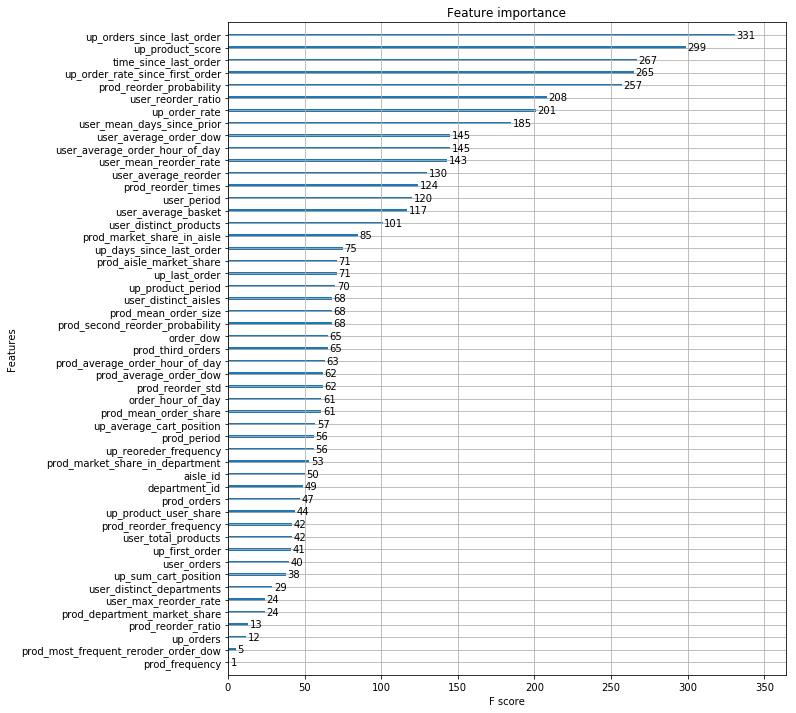

In [76]:
fig = plt.figure(figsize=(10,12))
ax = fig.add_subplot(1,1,1)
xgb.plot_importance(model, height=0.2, ax=ax)

### f1 score

In [ ]:
def f1_score(y_true, y_pred):

    y_true, y_pred = set(y_true), set(y_pred)
    
    p = sum([1 for i in y_pred if i in y_true]) / len(y_pred)
    
    r = sum([1 for i in y_true if i in y_pred]) / len(y_true)
    
    if p + r == 0:
        return 0
    return (2 * p * r) / (p + r)